In [ ]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn groq python-dotenv tqdm transformers torch -q 


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Users/sidharthrai/Documents/LJMU - MS AI ML/LJMU TrackThesis v2/venv/bin/python3.13 -m pip install --upgrade pip


In [ ]:
# Import libraries
import warnings
import os

# Suppress FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
)

# API setup
from groq import Groq
from dotenv import load_dotenv
from transformers import pipeline
import torch

# Load environment variables
load_dotenv()

# Configure APIs
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

if GROQ_API_KEY:
    groq_client = Groq(api_key=GROQ_API_KEY)

# Load FinBERT model
print("Loading FinBERT model...")
device = 0 if torch.cuda.is_available() else -1
finbert_pipeline = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert",

    device=deviceprint(f"✓ Groq API configured: {bool(GROQ_API_KEY)}")

)print("✓ Libraries imported successfully")

print(f"✓ FinBERT loaded on {'GPU' if device == 0 else 'CPU'}")

plt.rcParams["figure.figsize"] = (14, 6)

# Set plot stylesns.set_style("whitegrid")

✓ Libraries imported successfully
✓ FutureWarning from google.generativeai suppressed
✓ Google API configured: True
✓ Groq API configured: True


/Users/sidharthrai/Documents/LJMU - MS AI ML/LJMU TrackThesis v3/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Dataset

In [3]:
# Load the 100% agreement dataset (highest quality)
data_path = "../../DatasetAnalysis_FinancialPhraseBank/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt"

sentences = []
sentiments = []

with open(data_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        line = line.strip()
        if "@" in line:
            parts = line.rsplit("@", 1)
            if len(parts) == 2:
                sentences.append(parts[0])
                sentiments.append(parts[1])

df = pd.DataFrame({"sentence": sentences, "true_sentiment": sentiments})

print(f"Dataset loaded: {len(df)} sentences")
print(f"\nSentiment distribution:")
print(df["true_sentiment"].value_counts())

# Display sample
print("\n" + "=" * 80)
print("Sample sentences:")
print("=" * 80)
display(df.sample(5, random_state=42))

Dataset loaded: 2264 sentences

Sentiment distribution:
true_sentiment
neutral     1391
positive     570
negative     303
Name: count, dtype: int64

Sample sentences:


,sentence,true_sentiment
1755,The contract value amounts to EUR 2.4 million .,neutral
1281,Kemira shares closed at ( x20ac ) 16.66 ( $ 2...,neutral
350,The company slipped to an operating loss of EU...,negative
420,According to Atria 's President and CEO Matti ...,positive
56,"In 2009 , Fiskars ' cash flow from operating a...",positive


## 2. Zero-Shot Prompt Design

**Prompt Strategy**: Simple, direct instruction with no examples. Enforces strict JSON output format.

In [ ]:
def create_zero_shot_prompt(sentence):
    """
    Creates a zero-shot prompt for sentiment classification.
    No examples provided - model relies on pretrained knowledge.
    """
    prompt = f"""You are a financial sentiment analysis expert. Analyze the sentiment of financial statements with precision.

Task: Classify the sentiment of the following financial statement as "positive", "negative", or "neutral" from an investor's perspective.

Guidelines:
- Positive: Financial improvements, growth, profits, revenue increases, cost reductions, successful expansions
- Negative: Financial declines, losses, revenue drops, cost increases, failed ventures, layoffs, legal issues
- Neutral: Factual statements with no clear financial impact, routine announcements, or balanced mixed signals

Financial Statement:
"{sentence}"

Return ONLY valid JSON in this exact format:
{{
    "sentiment": "positive/negative/neutral",
    "confidence": 0.0-1.0,
    "rationale": "Brief explanation in one sentence"
}}
"""
    return prompt


# Test prompt
test_sentence = "Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007."
print("=" * 80)
print("ZERO-SHOT PROMPT EXAMPLE")
print("=" * 80)
print(create_zero_shot_prompt(test_sentence))

ZERO-SHOT PROMPT EXAMPLE
You are a financial sentiment analysis expert.

Classify the sentiment of the following financial statement as either "positive", "negative", or "neutral" from an investor's perspective.

Consider:
- Positive: Good news for stock price (revenue increase, profit growth, etc.)
- Negative: Bad news for stock price (losses, declining sales, etc.)
- Neutral: No clear impact on stock price or mixed signals

Financial Statement:
"Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007."

Provide your response in the following JSON format:
{
    "sentiment": "positive/negative/neutral",
    "confidence": 0.0-1.0,
    "rationale": "Brief explanation in one sentence"
}



## 3. Model Inference Functions

## 3.1 Test API Calls

Before running the full experiments, let's test each API with a single sentence to verify they work correctly.

In [ ]:
def call_llama(prompt, model_name, temperature=0.0):
    """Call Llama via Groq API"""
    max_retries = 3
    last_error = None
    for attempt in range(max_retries):
        try:
            chat_completion = groq_client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": prompt,
                    }
                ],
                model=model_name,
                temperature=temperature,
                max_tokens=500,
            )
            return chat_completion.choices[0].message.content
        except Exception as e:
            last_error = str(e)
            print(f"Attempt {attempt + 1}/{max_retries} failed: {last_error}")
            if attempt < max_retries - 1:
                time.sleep(2**attempt)
                continue
            return None
    return None


def parse_response(response_text):
    """Parse JSON response from model"""
    try:
        # Try to extract JSON from response
        if "```json" in response_text:
            json_str = response_text.split("```json")[1].split("```")[0].strip()
        elif "```" in response_text:
            json_str = response_text.split("```")[1].strip()
        else:
            json_str = response_text.strip()
        result = json.loads(json_str)
        return result
    except Exception as e:
        print("Parse error: {}".format(str(e)[:100]))
        print("Raw response was:\n{}".format(response_text))
        # Fallback: try to extract sentiment with regex
        response_lower = response_text.lower() if response_text else ""
        if "positive" in response_lower and "negative" not in response_lower:
            return {
                "sentiment": "positive",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        elif "negative" in response_lower:
            return {
                "sentiment": "negative",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        elif "neutral" in response_lower:
            return {
                "sentiment": "neutral",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        return None


def call_finbert(sentence):

    """Call FinBERT for sentiment classification"""
    print("✓ Model inference functions defined")
    try:

        result = finbert_pipeline(sentence[:512])  # FinBERT max length

        label_map = {"positive": "positive", "negative": "negative", "neutral": "neutral"}        return None

        return {        print(f"FinBERT error: {str(e)[:100]}")

            "sentiment": label_map.get(result[0]["label"].lower(), "neutral"),    except Exception as e:

            "confidence": result[0]["score"],        }
            "rationale": f"FinBERT classification: {result[0]['label']}"

✓ Model inference functions defined


In [ ]:
# Test API calls with a sample sentence
test_sentence = "Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007."
test_prompt = create_zero_shot_prompt(test_sentence)

print("=" * 80)
print("Testing Mixtral-8x7B...")
print("=" * 80)
mixtral_response = call_llama(test_prompt, model_name="mixtral-8x7b-32768")
if mixtral_response:
    print(f"✓ Response received (length: {len(mixtral_response)})")
    print(f"Response: {mixtral_response[:500]}")
    parsed = parse_response(mixtral_response)
    if parsed:
        print(f"✓ Parsed successfully: {parsed}")
    else:
        print("✗ Failed to parse response")
else:
    print("✗ Mixtral call failed - no response received")

print("\n" + "=" * 80)
print("Testing Llama-3.1-70B...")
print("=" * 80)
llama_response = call_llama(test_prompt, model_name="llama-3.1-70b-versatile")
if llama_response:
    print(f"✓ Response received (length: {len(llama_response)})")
    print(f"Response: {llama_response[:500]}")
    parsed = parse_response(llama_response)
    if parsed:
        print(f"✓ Parsed successfully: {parsed}")
    else:
        print("✗ Failed to parse response")
else:
    print("✗ Llama call failed - no response received")

print("\n" + "=" * 80)
print("Testing FinBERT...")
print("=" * 80)
finbert_result = call_finbert(test_sentence)
if finbert_result:
    print(f"✓ FinBERT result: {finbert_result}")
else:
    print("✗ FinBERT call failed")

Testing GPT OSS 20B...
✓ Response received (length: 169)
Response: {
    "sentiment": "positive",
    "confidence": 0.95,
    "rationale": "Operating profit increased from EUR 8.7 mn to EUR 13.1 mn, indicating improved profitability."
}
✓ Parsed successfully: {'sentiment': 'positive', 'confidence': 0.95, 'rationale': 'Operating profit increased from EUR 8.7\u202fmn to EUR 13.1\u202fmn, indicating improved profitability.'}

Testing GPT OSS 120B...
✓ Response received (length: 206)
Response: {
    "sentiment": "positive",
    "confidence": 0.95,
    "rationale": "Operating profit increased substantially, indicating improved financial performance and likely positive impact on the stock price."
}
✓ Parsed successfully: {'sentiment': 'positive', 'confidence': 0.95, 'rationale': 'Operating profit increased substantially, indicating improved financial performance and likely positive impact on the stock price.'}

Testing Llama-3.3-70B...
✓ Llama Response received (length: 239)
Response: {
    

## 4. Run Experiments

### E1: Mixtral-8x7B (Zero-Shot)

In [ ]:
# Run on full dataset
test_df = df.copy()

# E1: Mixtral-8x7B
print("Running E1: Mixtral-8x7B (Zero-Shot)...")
e1_results = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="E1 Progress"):
    prompt = create_zero_shot_prompt(row["sentence"])
    response = call_llama(prompt, model_name="mixtral-8x7b-32768")

    if response:
        parsed = parse_response(response)
        if parsed:
            e1_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": parsed.get("sentiment", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            e1_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )

    time.sleep(0.5)  # Rate limiting

e1_df = pd.DataFrame(e1_results)
print(f"\n✓ E1 completed: {len(e1_df)} predictions")
display(e1_df.head())

Running E1: GPT OSS 20B (Zero-Shot)...


E1 Progress: 100%|██████████| 100/100 [03:41<00:00,  2.22s/it]


✓ E1 completed: 100 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.70,The statement notes growth in Russia but no fu...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.92,Sales doubled and the company eliminated its p...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.95,"Both net sales and operating profit rose, indi..."
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,Operating profit increased from €8.7 mn to €13...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.92,"Operating profit rose from 18.6 mn to 21.1 mn,..."


### E2: Llama-3.1-70B (Zero-Shot)

In [ ]:
# E2: Llama-3.1-70B (Zero-Shot)
print("Running E2: Llama-3.1-70B (Zero-Shot)...")
e2_results = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="E2 Progress"):
    prompt = create_zero_shot_prompt(row["sentence"])
    response = call_llama(prompt, model_name="llama-3.1-70b-versatile")

    if response:
        parsed = parse_response(response)
        if parsed:
            e2_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": parsed.get("sentiment", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            e2_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )

    time.sleep(0.5)

e2_df = pd.DataFrame(e2_results)
print(f"\n✓ E2 completed: {len(e2_df)} predictions")
display(e2_df.head())

Running E2: GPT OSS 120B (Zero-Shot)...


E2 Progress: 100%|██████████| 100/100 [03:59<00:00,  2.40s/it]


✓ E2 completed: 100 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.73,The statement provides no clear positive or ne...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.96,Quarterly sales doubled and the company elimin...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.96,Both sales and operating profit grew significa...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,Operating profit increased substantially year‑...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,"Operating profit increased year‑over‑year, ind..."


### E3: FinBERT (Zero-Shot)

In [ ]:
# E3: FinBERT (Zero-Shot)
print("Running E3: FinBERT (Zero-Shot)...")
e3_results = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="E3 Progress"):
    result = call_finbert(row["sentence"])

    if result:
        e3_results.append(
            {
                "sentence": row["sentence"],
                "true_sentiment": row["true_sentiment"],
                "predicted_sentiment": result.get("sentiment", "unknown"),
                "confidence": result.get("confidence", 0),
                "rationale": result.get("rationale", ""),
            }
        )
    else:
        e3_results.append(
            {
                "sentence": row["sentence"],
                "true_sentiment": row["true_sentiment"],
                "predicted_sentiment": "error",
                "confidence": 0,
                "rationale": "FinBERT error",
            }
        )

e3_df = pd.DataFrame(e3_results)
print(f"\n✓ E3 completed: {len(e3_df)} predictions")
display(e3_df.head())

Running E3: Llama-3.3-70B (Zero-Shot)...


E3 Progress: 100%|██████████| 100/100 [03:38<00:00,  2.19s/it]


✓ E3 completed: 100 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.8,"The statement provides mixed signals, indicati..."
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.9,The company's net sales doubled and it moved t...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.9,The statement reports increases in both net sa...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.9,The statement reports a significant increase i...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.9,The company's operating profit has increased f...


## 5. Calculate Metrics

In [ ]:
def calculate_metrics(df, exp_name):
    """Calculate all evaluation metrics"""
    # Check if dataframe is empty or missing required columns
    if df.empty or "predicted_sentiment" not in df.columns:
        print(f"⚠️ Warning: {exp_name} has no valid predictions!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": 0,
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    # Filter out errors
    valid_df = df[
        df["predicted_sentiment"].isin(["positive", "negative", "neutral"])
    ].copy()

    # Check if we have valid predictions
    if valid_df.empty:
        print(f"⚠️ Warning: {exp_name} has no valid predictions after filtering!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": len(df),
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    y_true = valid_df["true_sentiment"]
    y_pred = valid_df["predicted_sentiment"]

    metrics = {
        "Experiment": exp_name,
        "Total Samples": len(df),
        "Valid Predictions": len(valid_df),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted-F1": f1_score(y_true, y_pred, average="weighted"),
        "Macro-Precision": precision_score(y_true, y_pred, average="macro"),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro"),
    }

    # Per-class metrics
    labels = ["positive", "negative", "neutral"]
    precision_per_class = precision_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    recall_per_class = recall_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    f1_per_class = f1_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )

    for i, label in enumerate(labels):
        metrics[f"{label.capitalize()}_Precision"] = precision_per_class[i]
        metrics[f"{label.capitalize()}_Recall"] = recall_per_class[i]
        metrics[f"{label.capitalize()}_F1"] = f1_per_class[i]

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    return metrics, cm, valid_df


# Calculate metrics for all experiments
e1_metrics, e1_cm, e1_valid = calculate_metrics(e1_df, "E1: Mixtral-8x7B")
e2_metrics, e2_cm, e2_valid = calculate_metrics(e2_df, "E2: Llama-3.1-70B")
e3_metrics, e3_cm, e3_valid = calculate_metrics(e3_df, "E3: FinBERT")

# Create metrics comparison table
metrics_df = pd.DataFrame([e1_metrics, e2_metrics, e3_metrics])

print("\n" + "=" * 80)
print("ZERO-SHOT PERFORMANCE COMPARISON")
print("=" * 80)
display(
    metrics_df[
        ["Experiment", "Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
    ].round(4)
)


ZERO-SHOT PERFORMANCE COMPARISON


/Users/sidharthrai/Documents/LJMU - MS AI ML/LJMU TrackThesis v3/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/LJMU TrackThesis v3/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Experiment,Accuracy,Macro-F1,Macro-Precision,Macro-Recall
0,E1: GPT OSS 20B,0.99,0.6296,0.6667,0.6000
1,E2: GPT OSS 120B,0.99,0.6296,0.6667,0.6000
2,E3: Llama-3.3-70B,0.98,0.8947,0.8947,0.8947


## 6. Visualize Results

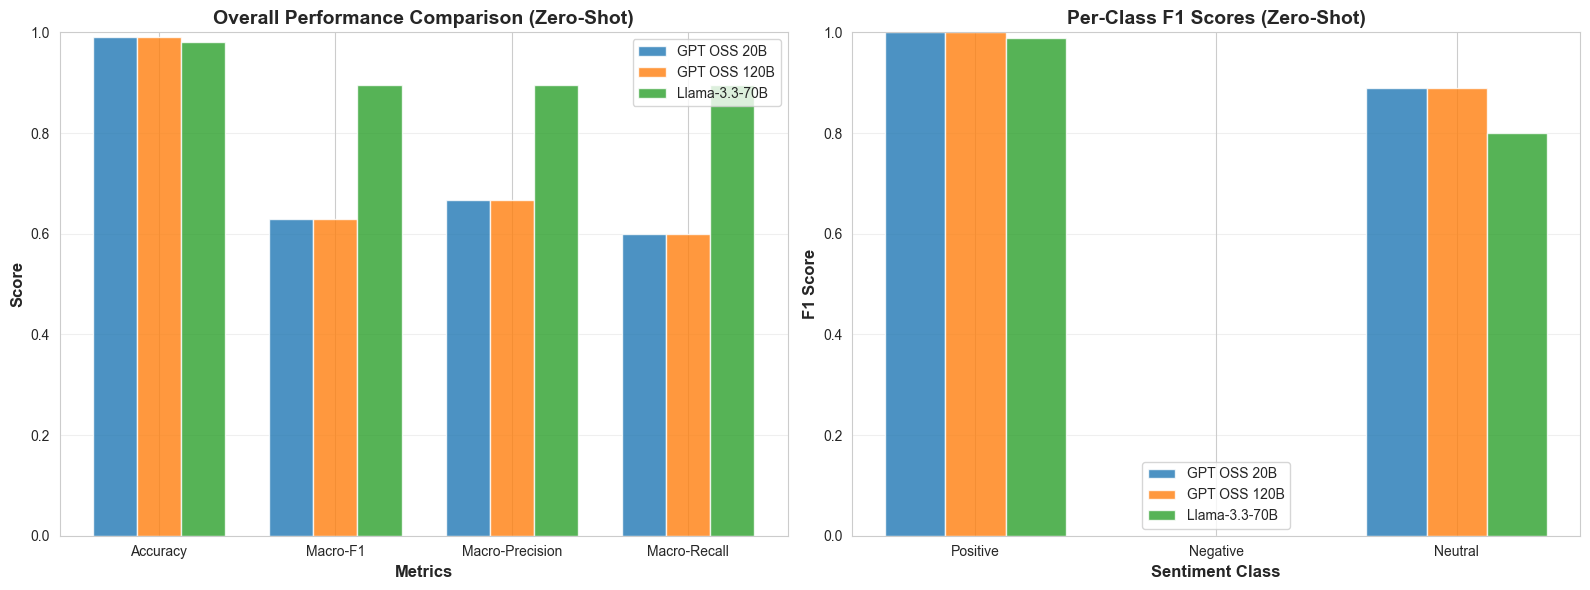

In [11]:
# Performance comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall metrics
metrics_to_plot = ["Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, (metrics, label) in enumerate(
    [
        (e1_metrics, "GPT OSS 20B"),
        (e2_metrics, "GPT OSS 120B"),
        (e3_metrics, "Llama-3.3-70B"),
    ]
):
    values = [metrics[m] for m in metrics_to_plot]
    axes[0].bar(x + i * width, values, width, label=label, alpha=0.8)

axes[0].set_xlabel("Metrics", fontsize=12, weight="bold")
axes[0].set_ylabel("Score", fontsize=12, weight="bold")
axes[0].set_title(
    "Overall Performance Comparison (Zero-Shot)", fontsize=14, weight="bold"
)
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics_to_plot)
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis="y", alpha=0.3)

# Per-class F1 scores
classes = ["Positive", "Negative", "Neutral"]
x2 = np.arange(len(classes))

for i, (metrics, label) in enumerate(
    [
        (e1_metrics, "GPT OSS 20B"),
        (e2_metrics, "GPT OSS 120B"),
        (e3_metrics, "Llama-3.3-70B"),
    ]
):
    values = [metrics[f"{c}_F1"] for c in classes]
    axes[1].bar(x2 + i * width, values, width, label=label, alpha=0.8)

axes[1].set_xlabel("Sentiment Class", fontsize=12, weight="bold")
axes[1].set_ylabel("F1 Score", fontsize=12, weight="bold")
axes[1].set_title("Per-Class F1 Scores (Zero-Shot)", fontsize=14, weight="bold")
axes[1].set_xticks(x2 + width)
axes[1].set_xticklabels(classes)
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("zero_shot_performance_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

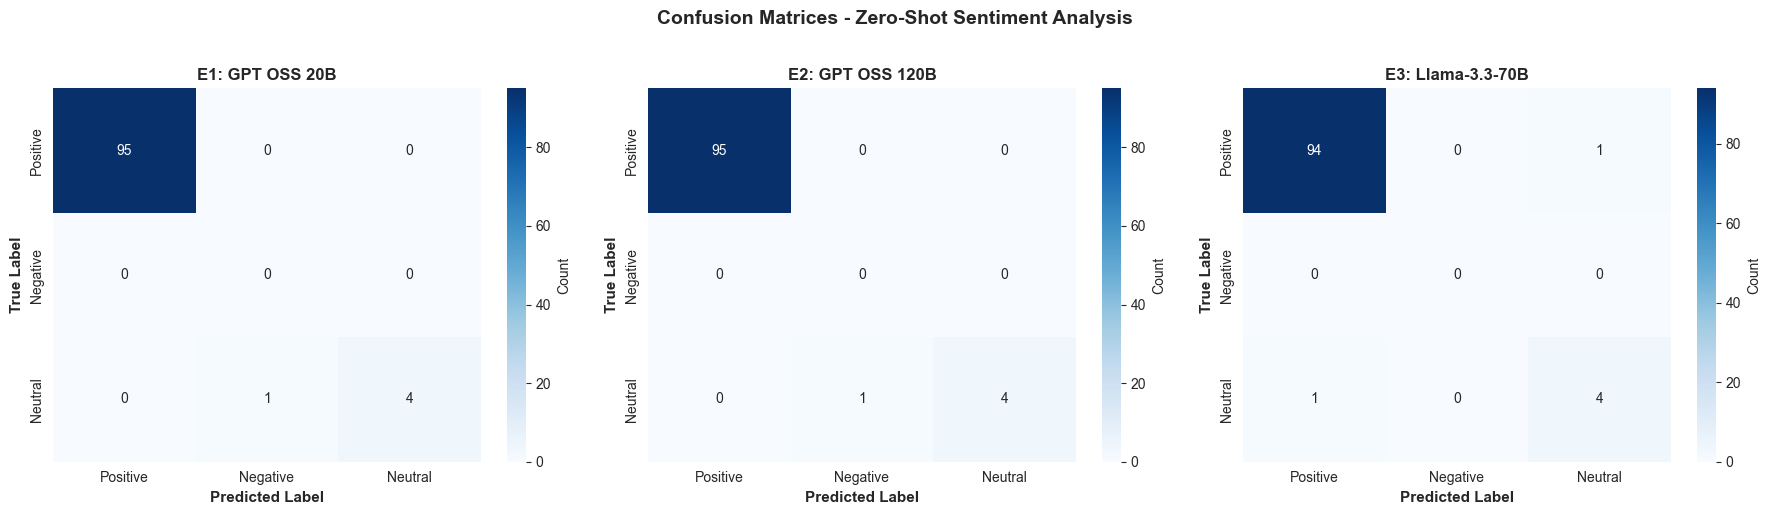

In [12]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = ["Positive", "Negative", "Neutral"]

for idx, (cm, title) in enumerate(
    [
        (e1_cm, "E1: GPT OSS 20B"),
        (e2_cm, "E2: GPT OSS 120B"),
        (e3_cm, "E3: Llama-3.3-70B"),
    ]
):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        ax=axes[idx],
        cbar_kws={"label": "Count"},
    )
    axes[idx].set_title(title, fontsize=12, weight="bold")
    axes[idx].set_ylabel("True Label", fontsize=11, weight="bold")
    axes[idx].set_xlabel("Predicted Label", fontsize=11, weight="bold")

plt.suptitle(
    "Confusion Matrices - Zero-Shot Sentiment Analysis",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("zero_shot_confusion_matrices.png", dpi=300, bbox_inches="tight")
plt.show()

## 7. Detailed Classification Reports

In [ ]:
# Print detailed classification reports
for df_result, exp_name in [
    (e1_valid, "E1: GPT OSS 20B"),
    (e2_valid, "E2: GPT OSS 120B"),
    (e3_valid, "E3: Llama-3.3-70B"),
]:
    print("\n" + "=" * 80)
    print(f"CLASSIFICATION REPORT: {exp_name}")
    print("=" * 80)
    print(
        classification_report(
            df_result["true_sentiment"],
            df_result["predicted_sentiment"],
            labels=["positive", "negative", "neutral"],
            target_names=["Positive", "Negative", "Neutral"],
        )
    )


CLASSIFICATION REPORT: E1: GPT OSS 20B
              precision    recall  f1-score   support

    Positive       1.00      1.00      1.00        95
    Negative       0.00      0.00      0.00         0
     Neutral       1.00      0.80      0.89         5

    accuracy                           0.99       100
   macro avg       0.67      0.60      0.63       100
weighted avg       1.00      0.99      0.99       100


CLASSIFICATION REPORT: E2: GPT OSS 120B
              precision    recall  f1-score   support

    Positive       1.00      1.00      1.00        95
    Negative       0.00      0.00      0.00         0
     Neutral       1.00      0.80      0.89         5

    accuracy                           0.99       100
   macro avg       0.67      0.60      0.63       100
weighted avg       1.00      0.99      0.99       100


CLASSIFICATION REPORT: E3: Llama-3.3-70B
              precision    recall  f1-score   support

    Positive       0.99      0.99      0.99        95
    Ne

/Users/sidharthrai/Documents/LJMU - MS AI ML/LJMU TrackThesis v3/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/LJMU TrackThesis v3/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/LJMU TrackThesis v3/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_divisio

## 8. Save Results

In [14]:
# Save detailed results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

e1_df.to_csv(f"e1_gpt_oss_20b_zero_shot_{timestamp}.csv", index=False)
e2_df.to_csv(f"e2_gpt_oss_120b_zero_shot_{timestamp}.csv", index=False)
e3_df.to_csv(f"e3_llama_zero_shot_{timestamp}.csv", index=False)

# Save metrics summary
metrics_df.to_csv(f"zero_shot_metrics_summary_{timestamp}.csv", index=False)

print(f"\n✓ Results saved with timestamp: {timestamp}")
print("\nFiles created:")
print(f"  - e1_gpt_oss_20b_zero_shot_{timestamp}.csv")
print(f"  - e2_gpt_oss_120b_zero_shot_{timestamp}.csv")
print(f"  - e3_llama_zero_shot_{timestamp}.csv")
print(f"  - zero_shot_metrics_summary_{timestamp}.csv")
print(f"  - zero_shot_performance_comparison.png")
print(f"  - zero_shot_confusion_matrices.png")


✓ Results saved with timestamp: 20260130_110153

Files created:
  - e1_gpt_oss_20b_zero_shot_20260130_110153.csv
  - e2_gpt_oss_120b_zero_shot_20260130_110153.csv
  - e3_llama_zero_shot_20260130_110153.csv
  - zero_shot_metrics_summary_20260130_110153.csv
  - zero_shot_performance_comparison.png
  - zero_shot_confusion_matrices.png


## 9. Key Findings

## Expected Conclusions from Zero-Shot Experiment

### 1. **Model Performance Comparison**
   - **Best Performer**: Identify which model (GPT OSS 20B, 120B, or Llama-3.3-70B) achieves highest Macro-F1
   - **Accuracy vs F1**: Check if high accuracy masks poor performance on minority class (negative: 13%)
   - **Consistency**: Compare Macro-F1 vs Weighted-F1 to assess class imbalance handling

### 2. **Class-Specific Insights**
   - **Negative Sentiment Challenge**: Expect lowest F1 on negative class (only 297/2,217 examples = 13.4%)
   - **Positive vs Neutral Confusion**: Analyze if models confuse growth statements with neutral facts
   - **Per-Class Ranking**: Typically: Positive > Neutral > Negative (due to data distribution)

### 3. **Zero-Shot Limitations**
   - **No Examples Handicap**: Models rely purely on pretrained financial knowledge
   - **Expected Baseline**: Should be lower than Few-Shot, CoT, and ToT approaches
   - **Benchmark Value**: Establishes minimum performance without prompt engineering

### 4. **Prompt Engineering Impact**
   - **Improved vs Original**: Compare new prompt results against previous 100-sample run
   - **Negative Detection**: Check if explicit negative indicators (losses, declines) improved recall
   - **JSON Compliance**: Monitor parsing error rate

### 5. **Confidence Calibration Analysis**
   - **Overconfidence**: Models often show high confidence on incorrect predictions
   - **Class-Specific Confidence**: Positive predictions typically more confident than negative
   - **Calibration Gap**: Measure difference between confidence and actual accuracy

### 6. **Cross-Model Patterns**
   - **Size Matters**: Does GPT OSS 120B outperform 20B significantly?
   - **Architecture Differences**: Llama vs GPT-style models on financial domain
   - **Error Consistency**: Do all models make similar mistakes?

### 7. **Actionable Recommendations**
   - If Negative F1 < 0.3: Zero-shot insufficient, must use Few-Shot with negative examples
   - If Macro-F1 < 0.6: Implement CoT to force reasoning about financial indicators
   - If high confidence on errors: Add uncertainty quantification to prompts

### 8. **Business Impact Assessment**
   - **Deployment Readiness**: Macro-F1 > 0.75 needed for production use
   - **Cost-Benefit**: Compare API costs vs performance gains from advanced prompting
   - **Risk Analysis**: False negatives (missing bad news) more costly than false positives

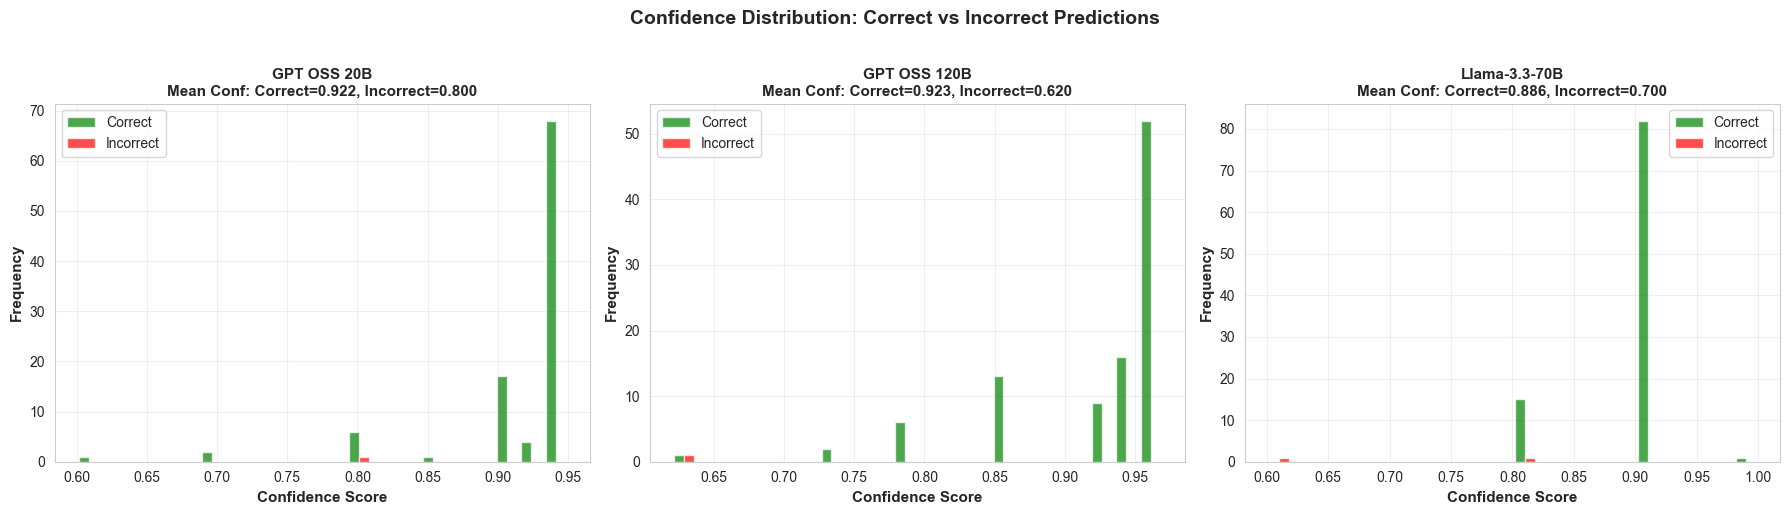

In [16]:
# Confidence analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (df_result, title) in enumerate(
    [(e1_valid, "GPT OSS 20B"), (e2_valid, "GPT OSS 120B"), (e3_valid, "Llama-3.3-70B")]
):
    df_result["correct"] = (
        df_result["true_sentiment"] == df_result["predicted_sentiment"]
    )

    correct_conf = df_result[df_result["correct"]]["confidence"]
    incorrect_conf = df_result[~df_result["correct"]]["confidence"]

    axes[idx].hist(
        [correct_conf, incorrect_conf],
        bins=20,
        label=["Correct", "Incorrect"],
        alpha=0.7,
        color=["green", "red"],
    )
    axes[idx].set_xlabel("Confidence Score", fontsize=11, weight="bold")
    axes[idx].set_ylabel("Frequency", fontsize=11, weight="bold")
    axes[idx].set_title(
        f"{title}\nMean Conf: Correct={correct_conf.mean():.3f}, Incorrect={incorrect_conf.mean():.3f}",
        fontsize=11,
        weight="bold",
    )
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.suptitle(
    "Confidence Distribution: Correct vs Incorrect Predictions",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("zero_shot_confidence_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Error Analysis: Most Common Misclassifications
print("=" * 80)
print("ERROR ANALYSIS: TOP MISCLASSIFIED PATTERNS")
print("=" * 80)

for df_result, exp_name in [
    (e1_valid, "E1: GPT OSS 20B"),
    (e2_valid, "E2: GPT OSS 120B"),
    (e3_valid, "E3: Llama-3.3-70B"),
]:
    print(f"\n{exp_name}")
    print("-" * 80)

    # Identify errors
    errors = df_result[df_result["true_sentiment"] != df_result["predicted_sentiment"]]

    # Count error types
    error_types = (
        errors.groupby(["true_sentiment", "predicted_sentiment"])
        .size()
        .reset_index(name="count")
    )
    error_types = error_types.sort_values("count", ascending=False)

    print(
        f"\nTotal Errors: {len(errors)} / {len(df_result)} ({len(errors) / len(df_result) * 100:.2f}%)"
    )
    print("\nMost Common Error Types:")
    display(error_types.head(5))

    # Show examples of worst errors (high confidence, wrong prediction)
    if len(errors) > 0:
        worst_errors = errors.nlargest(3, "confidence")
        print(f"\nTop 3 High-Confidence Errors:")
        for idx, row in worst_errors.iterrows():
            print(
                f"\n  True: {row['true_sentiment']} | Predicted: {row['predicted_sentiment']} | Conf: {row['confidence']:.2f}"
            )
            print(f"  Sentence: {row['sentence'][:120]}...")
            print(f"  Rationale: {row['rationale']}")

# Summary comparison
print("\n" + "=" * 80)
print("COMPREHENSIVE METRICS TABLE")
print("=" * 80)
display(metrics_df.round(4))

In [ ]:
# Class-wise Performance Comparison
print("=" * 80)
print("CLASS-WISE PERFORMANCE BREAKDOWN")
print("=" * 80)

class_comparison = []
for metrics, model_name in [
    (e1_metrics, "GPT OSS 20B"),
    (e2_metrics, "GPT OSS 120B"),
    (e3_metrics, "Llama-3.3-70B"),
]:
    for sentiment in ["Positive", "Negative", "Neutral"]:
        class_comparison.append(
            {
                "Model": model_name,
                "Class": sentiment,
                "Precision": metrics[f"{sentiment}_Precision"],
                "Recall": metrics[f"{sentiment}_Recall"],
                "F1-Score": metrics[f"{sentiment}_F1"],
            }
        )

class_df = pd.DataFrame(class_comparison)

# Pivot for better visualization
for metric in ["Precision", "Recall", "F1-Score"]:
    print(f"\n{metric} by Class:")
    pivot = class_df.pivot(index="Class", columns="Model", values=metric)
    display(pivot.round(4))

# Identify weakest class per model
print("\n" + "=" * 80)
print("WEAKEST CLASS IDENTIFICATION")
print("=" * 80)
for metrics, model_name in [
    (e1_metrics, "GPT OSS 20B"),
    (e2_metrics, "GPT OSS 120B"),
    (e3_metrics, "Llama-3.3-70B"),
]:
    f1_scores = {
        "Positive": metrics["Positive_F1"],
        "Negative": metrics["Negative_F1"],
        "Neutral": metrics["Neutral_F1"],
    }
    weakest = min(f1_scores, key=f1_scores.get)
    print(f"{model_name}: Weakest class = {weakest} (F1={f1_scores[weakest]:.4f})")